In [80]:
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle
import sklearn
import os
import csv

Importing Maori lexicon

http://nzetc.victoria.ac.nz/tm/scholarly/tei-legalMaoriCorpus.html#legal_maori_lexicon.

http://www.maori.info/maori_language.htm

http://tereomaori.tki.org.nz/Teacher-tools/Te-Whakaipurangi-Rauemi/High-frequency-word-lists

Removed macrons, parentheses etc from file in Sublime Text.

In [2]:
maori_lexicon = set([])

with open('../data/raw/maori_legal_lexicon.csv', 'rb') as f:
    reader = csv.reader(f)
    rough_list = list(reader)
    for item in rough_list:
        for word in item:
            if (word!='' and ~word.isdigit()):
                for i in word.split(' '):
                    maori_lexicon.add(i.lower())
f.close()

with open('../data/raw/maori_lexicon.csv', 'rb') as f:
    reader = csv.reader(f)
    rough_list = list(reader)
    for item in rough_list:
        for word in item:
            maori_lexicon.add(word.lower())
f.close()

#Need to remove single letters, 'no' and 'one' which are a common source of false positives            
to_remove = ['','me','no','one','a','e','i','o','u','ii']            

for letter in to_remove:
    maori_lexicon.remove(letter)

Using a slightly edited verison of the first ~2000 from https://github.com/first20hours/google-10000-english/blob/master/20k.txt

http://www.quietaffiliate.com/free-first-name-and-last-name-databases-csv-and-sql/

In [7]:
english_lexicon = set([])

with open('../data/raw/english_lexicon_top_2000.csv', 'rb') as f:
    reader = csv.reader(f)
    rough_list = list(reader)
    for wordlist in rough_list:
        for word in wordlist:
            english_lexicon.add(word.lower())
f.close()
            
with open('../data/raw/CSV_Database_of_First_And_Last_Names/CSV_Database_of_First_Names.csv', 'rU') as f:
    reader = csv.reader(f)
    rough_list = list(reader)
    for wordlist in rough_list:
        for word in wordlist:
            english_lexicon.add(word.lower())
f.close()

with open('../data/raw/CSV_Database_of_First_And_Last_Names/CSV_Database_of_Last_Names.csv', 'rU') as f:
    reader = csv.reader(f)
    rough_list = list(reader)
    for wordlist in rough_list:
        for word in wordlist:
            english_lexicon.add(word.lower())  
f.close()
            
with open('../data/raw/misclassified-as-maori.csv', 'rb') as f:
    reader = csv.reader(f)
    rough_list = list(reader)
    for wordlist in rough_list:
        for word in wordlist:
            english_lexicon.add(word.lower())
f.close()

english_lexicon = english_lexicon.difference(maori_lexicon)
english_lexicon.remove('')

In [8]:
print len(english_lexicon)

93170


In [9]:
def word2features(word,maori=True):
    """Returns a word length normalized vector of all letter frequencies and bigrams.
       First entry is word, second is whether it is a Maori word or not."""
    if maori == True:
        features = [word,1]
    else:
        features = [word,0]
    word_length = len(word)
    alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l',
                'm','n','o','p','q','r','s','t','u','v','w','y','z']
    for letter in alphabet:
        features.append(word.count(letter)/float(word_length))
    for first_letter in alphabet:
        for second_letter in alphabet:
            features.append(word.count(first_letter+second_letter)/float(word_length))
    return features

In [10]:
words = []
for word in maori_lexicon:
    words.append(word2features(word))
for word in english_lexicon:
    words.append(word2features(word,maori=False))

In [11]:
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l',
            'm','n','o','p','q','r','s','t','u','v','w','y','z']
column_names = ['word', 'maori_binary']
for letter in alphabet:
    column_names.append(letter)
for first_letter in alphabet:
    for second_letter in alphabet:
        column_names.append(first_letter+second_letter)

In [12]:
words_df = pd.DataFrame(words)
words_df.columns = column_names
print words_df.head()

           word  maori_binary         a    b    c    d         e    f  \
0         ainga             1  0.400000  0.0  0.0  0.0  0.000000  0.0   
1       kahore              1  0.142857  0.0  0.0  0.0  0.142857  0.0   
2         putua             1  0.200000  0.0  0.0  0.0  0.000000  0.0   
3        takahe             1  0.333333  0.0  0.0  0.0  0.166667  0.0   
4  whakaminenga             1  0.250000  0.0  0.0  0.0  0.083333  0.0   

          g         h ...    zp   zq   zr   zs   zt   zu   zv   zw   zy   zz  
0  0.200000  0.000000 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.000000  0.142857 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.000000  0.000000 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.000000  0.166667 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.083333  0.083333 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 652 columns]


In [13]:
X = words_df.drop(['word','maori_binary'],axis=1).values
y = words_df['maori_binary']

In [27]:
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix

In [15]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
cm = np.array([[0,0],[0,0]])
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rus = RandomUnderSampler(ratio=0.3)
    X_train, y_train = rus.fit_sample(X_train,y_train)
    ros = RandomOverSampler()
    X_train, y_train = ros.fit_sample(X_train,y_train)
    model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100, \
                              silent=True, objective='binary:logistic', nthread=-1, \
                              gamma=0, min_child_weight=1, max_delta_step=0, \
                              subsample=1, colsample_bytree=1, colsample_bylevel=1, \
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, \
                              base_score=0.5, missing=None)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm += confusion_matrix(y_test, y_pred)
print cm

[[88600  4570]
 [   10  2595]]


In [31]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
cm = np.array([[0,0],[0,0]])
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rus = RandomUnderSampler()
    X_train, y_train = rus.fit_sample(X_train,y_train)
    ros = RandomOverSampler()
    X_train, y_train = ros.fit_sample(X_train,y_train)
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm += confusion_matrix(y_test, y_pred)
print cm

[[89424  3746]
 [    2  2603]]


In [32]:
final_model = GaussianNB()
rus = RandomUnderSampler()
X_train, y_train = rus.fit_sample(X,y)
ros = RandomOverSampler()
X_train, y_train = ros.fit_sample(X_train,y_train)
final_model.fit(X_train, y_train)

GaussianNB(priors=None)

Which words does the model get wrong?

In [34]:
maori_misclassified = []

for word in maori_lexicon:
    test=[]
    test.append(word2features(word))
    test_df = pd.DataFrame(test)
    binary = final_model.predict(test_df.drop([0,1],axis=1).values)
    if binary == 0:
        maori_misclassified.append(word)

print maori_misclassified[0:100]

english_misclassified = []

for word in english_lexicon:
    test=[]
    test.append(word2features(word))
    test_df = pd.DataFrame(test)
    binary = final_model.predict(test_df.drop([0,1],axis=1).values)
    if binary == 1:
        english_misclassified.append(word)
    if len(english_misclassified)==100:
        print english_misclassified
        break

[]
['hanging', 'goonan', 'wang', 'kuen', 'nanik', 'nania', 'gata', 'peetoom', 'magano', 'magana', 'pinon', 'nature', 'tonini', 'hepa', 'hone', 'hong', 'noxon', 'hai', 'ham', 'hae', 'har', 'haw', 'kamaka', 'raper', 'iwaoka', 'ingemi', 'okinaka', 'minute', 'reining', 'honour', 'riemer', 'miehe', 'amarian', 'poaipuni', 'agamao', 'gieringer', 'potier', 'hamer', 'tamaro', 'tamara', 'tarone', 'romon', 'rehak', 'pepitone', 'houpe', 'moone', 'mamone', 'weiher', 'kimura', 'morentin', 'ramoutar', 'paniagua', 'kominek', 'kira', 'auter', 'auten', 'heenan', 'rago', 'romito', 'maximum', 'nora', 'nori', 'aharoni', 'mori', 'moro', 'mora', 'more', 'emuka', 'papen', 'paper', 'menear', 'arakawa', 'weier', 'rieke', 'noma', 'miao', 'miah', 'naoma', 'naomi', 'mauer', 'moxham', 'tim', 'parente', 'parenti', 'ranum', 'khuu', 'aguinaga', 'taake', 'katin', 'katie', 'gimar', 'haxton', 'guarin', 'nieto', 'maker', 'meurin', 'tahon', 'turano', 'panone', 'penunuri']


Coding a classifier for road names. Since the road names contain numbers, spaces, hyphens and uppercase letters there's a bit of cleaning to be done on each road name.
1. Each roadname is split into a list of words, if there's only one word then it's a list containing only the word.
2. A series of tests are applied to each word in the list, if any of the indicators are that it's a Maori word then the function returns True, otherwise it continues on through each word in the name until it either finds a Maori word or runs out of words and returns False.

The tests are as follows:
1. Is the word in the Maori lexicon?
2. Is the word in the English lexicon?
3. Does the word contain any letters which do not appear in the Maori alphabet?
4. Is the word a number?
5. Does the word end in something other than a vowel (all Maori words end in a vowel)?
6. Does the word classifier predict the word is Maori?

A word is only classified as Maori if it is either in the Maori lexicon OR if it answers no to tests 2-5 AND the word classifier predicts it is Maori. The ultimate aim here is to use the word classifier as little as possible since it is likely to be the most fallible.

In [18]:
def classify_as_maori(word):
    word = str(word)
    wordlist = word.lower().replace('-',' ').split()
    non_maori_letters = set(['b','c','d','f','j','l','q','s','v','x','y','z'])
    for word in wordlist:
        if word in maori_lexicon:
            return 1
        elif word in english_lexicon:
            pass
        elif any((char in non_maori_letters) for char in word):
            pass
        elif word.isdigit():
            pass
        elif word[-1] not in ['a','e','i','o','u']:
            pass
        elif final_model.predict(pd.DataFrame([word2features(word)]).drop([0,1],axis=1).values)==1:
            return 1
    return 0

def classify_as_maori_diagnose(word):
    word = str(word)
    wordlist = word.lower().replace('-',' ').split()
    non_maori_letters = set(['b','c','d','f','j','l','q','s','v','x','y','z'])
    for word in wordlist:
        if word in maori_lexicon:
            print word,1
            return True
        elif word in english_lexicon:
            print word,2
            pass
        elif any((char in non_maori_letters) for char in word):
            print word,3
            pass
        elif word.isdigit():
            print word,4
            pass
        elif final_model.predict(pd.DataFrame([word2features(word)]).drop([0,1],axis=1).values)==1:
            print word,5
            return True
    return False

# NZ Road Names

Downloaded the NZ Roads Addressing database https://data.linz.govt.nz

In [19]:
nz_roads_df = pd.read_csv('../data/raw/lds-nz-roads-addressing-CSV/nz-roads-addressing.csv')
nz_road_subsections_df = pd.read_csv('../data/raw/lds-nz-roads-subsections-addressing-CSV/nz-roads-subsections-addressing.csv')
nz_roads_df.drop(['WKT','full_road_name', 'geometry_class', 'road_name_class','road_name_label', 
                  'road_name_prefix', 'road_name_body', 'road_type',
                  'road_name_type', 'road_name_suffix', 'route_name_body', 'route_name_number',
                  'route_name_alpha', 'route_name_suffix', 'road_name_label_ascii'],
                 axis=1, inplace=True)
nz_road_subsections_df.drop(['WKT', 'road_section_geometry_id', 'road_section_id', 'geometry_class',
                             'road_type', 'road_section_type','address_range_road_id', 'full_road_name',
                             'road_name_label','full_road_name_ascii', 'road_name_label_ascii',
                             'road_name_body_ascii', 'secondary_road_name_ascii','road_name_prefix',
                             'road_name_body','road_name_type','road_name_suffix','secondary_road_name',
                             'full_route_name', 'secondary_route_name','tertiary_route_name', 
                             'left_suburb_locality', 'right_suburb_locality','left_town_city', 'right_town_city',
                             'left_suburb_locality_ascii','right_suburb_locality_ascii', 'left_town_city_ascii',
                             'right_town_city_ascii','right_territorial_authority'],
                            axis=1, inplace=True)
nz_road_subsections_df.drop_duplicates(inplace=True)
nz_roads_df = pd.merge(nz_roads_df, nz_road_subsections_df, how='inner', on='road_id')
nz_roads_df.dropna(inplace=True)
print nz_roads_df.sample(20)
print nz_roads_df.shape

/Users/Reed/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Reed/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


       road_id full_road_name_ascii road_name_body_ascii  \
67266  1804329  Ivan Jamieson Place        Ivan Jamieson   
34123  1815774       Riverview Road            Riverview   
30517  3060777          Pullin Road               Pullin   
128    1772203         Matai Street                Matai   
3690   3009724       Salford Street              Salford   
21143  1836458       Parkville Road            Parkville   
22220  1838286        Villino Place              Villino   
17933  1830334      Kingswood Place            Kingswood   
61738  1809709      Daniel Crescent               Daniel   
51989  1784941       Glenbrae Place             Glenbrae   
12724  1776246        Liffey Street               Liffey   
17957  1830369       Isabella Drive             Isabella   
1481   1794654          Cabot Place                Cabot   
48680  1782466      St Martins Road           St Martins   
7857   1807921          Karaka Road               Karaka   
24863  1841733        Tea Tree Lane     

In [35]:
nz_roads_df['maori_name'] = nz_roads_df['road_name_body_ascii'].apply(classify_as_maori)
print 'There are %d non-Maori roads' % len(nz_roads_df[nz_roads_df['maori_name']==0])
print 'There are %d Maori roads' % len(nz_roads_df[nz_roads_df['maori_name']==1])

There are 58521 non-Maori roads
There are 13238 Maori roads


In [37]:
print nz_roads_df['road_name_body_ascii'].value_counts().head(20)
print len(nz_roads_df['road_name_body_ascii'].unique())
print nz_roads_df[nz_roads_df['maori_name']==0]['road_name_body_ascii'].value_counts().head(20)
print len(nz_roads_df[nz_roads_df['maori_name']==0]['road_name_body_ascii'].unique())
print nz_roads_df[nz_roads_df['maori_name']==1]['road_name_body_ascii'].value_counts().head(20)
print len(nz_roads_df[nz_roads_df['maori_name']==1]['road_name_body_ascii'].unique())

Park         115
Kowhai        97
Totara        93
Church        92
Beach         91
Victoria      90
King          89
Wilson        88
George        86
Rata          86
Tui           84
Rimu          83
Campbell      81
Main          81
Station       79
High          78
Russell       75
Queen         74
Elizabeth     73
Matai         73
Name: road_name_body_ascii, dtype: int64
31179
Park         115
Church        92
Beach         91
Victoria      90
King          89
Wilson        88
George        86
Main          81
Campbell      81
Station       79
High          78
Russell       75
Queen         74
Elizabeth     73
River         72
Hall          71
Mill          71
School        68
Railway       68
Grey          62
Name: road_name_body_ascii, dtype: int64
23921
Kowhai        97
Totara        93
Rata          86
Tui           84
Rimu          83
Matai         73
Miro          62
Kauri         62
Kiwi          54
Huia          53
Puriri        53
Manuka        52
Moana         49
Tawa 

In [38]:
district_percent_df = nz_roads_df.groupby(['left_territorial_authority'],as_index=False)['maori_name'].mean()
authority_counts = pd.DataFrame(nz_roads_df['left_territorial_authority'].value_counts())
authority_counts.reset_index(level=0,inplace=True)
authority_counts.columns = ['left_territorial_authority','number_of_roads']
district_percent_df = pd.merge(district_percent_df, authority_counts, how='inner', on='left_territorial_authority')
district_percent_df.columns = ['territorial_authority','percent_maori','number_of_roads']

pd.set_option('display.max_rows', len(district_percent_df))
print district_percent_df
pd.reset_option('display.max_rows')

                 territorial_authority  percent_maori  number_of_roads
0   Area Outside Territorial Authority       0.473684               19
1                   Ashburton District       0.034696              807
2                             Auckland       0.144822            13230
3                      Buller District       0.077381              504
4                   Carterton District       0.183962              212
5         Central Hawke's Bay District       0.200837              478
6               Central Otago District       0.061957              920
7            Chatham Islands Territory       0.484848               33
8                    Christchurch City       0.074339             4466
9                      Clutha District       0.102375             1221
10                        Dunedin City       0.067979             2236
11                  Far North District       0.380282             1633
12                   Gisborne District       0.355932              944
13    

In [39]:
print list(nz_roads_df[(nz_roads_df['left_territorial_authority']=='Chatham Islands Territory') 
                       & (nz_roads_df['maori_name']==0)]['road_name_body_ascii'])

['Hospital', 'Holmes', 'Wilson', 'Comflat', 'Air Base', 'Donaldsons', 'Hospital', 'Port Hutt', 'North', 'Meteorological', 'Flower Pot-Glory', 'Flower Pot-Glory', 'Highet', 'Northhead', 'Paynters', 'Hotel', 'Fish Factory']


In [41]:
print list(nz_roads_df[nz_roads_df['maori_name']==1]['road_name_body_ascii'].sample(100))
print list(nz_roads_df[nz_roads_df['maori_name']==0]['road_name_body_ascii'].sample(100))

['Kapuka', 'Hokimai Bay', 'Waitui', 'Pukeko', 'Wainui', 'Hakawai', 'Haputone', 'Otaio River', 'Te Punga', 'Titoki', 'Motutara', 'Ngatiwai', 'Te Heke', 'Ngatoka', 'Ngapera', 'Puriri', 'Titoki', 'Horotutu', 'Nikau', 'Otawhiwhi', 'Matapaua Bay', 'Ruru', 'Oparure', 'Opawe', 'Wharekauri', 'Kaiuru', 'Kiekie', 'Maori', 'Otaipango', 'Taupiri', 'Rimu', 'Waipuka', 'Totara Views', 'Hei Hei', 'Te Rahu', 'Swamp Kauri', 'Whakaipo', 'Waihi Gorge', 'Mangaroa Valley', 'Tai', 'Karepa', 'Kamahi', 'Makerikeri', 'Totara', 'Wharemauku', 'Opahi Bay', 'Hukerenui', 'Kahu', 'Pomona', 'Ngataipua', 'Johnsonville Porirua', 'Manuka', 'Raetihi', 'Waikaka', 'Tamatea', 'Kaipara', 'Tawa', 'Kapiro', 'Mutuera', 'Marae', 'Rapata', 'Autawa', 'Kaikomako', 'Hokianga', 'Korito', 'Ruapapa', 'Ranginui', 'Miro', 'Opawa', 'Tangaruhe', 'Papanui Inlet', 'Wiira', 'Rangikapiti', 'Pito-One', 'Pakotai', 'Akatere', 'Rewi', 'Rata', 'Witiora', 'Waikite', 'Pa', 'Kokotau', 'Karaka', 'Waipuna', 'Wiremu', 'Te Rauamoa', 'Mangatete', 'Kowhai', 

In [103]:
district_percent_dict = district_percent_df.set_index('territorial_authority').to_dict()
district_percents = district_percent_dict['percent_maori']

Translate the district level data to the regional level. Some districts are in multiple regions which complicates things slightly.

In [97]:
district_percent_dict = district_percent_df.set_index('territorial_authority').to_dict()
district_to_region = {'Northland Region' : ['Far North District', 'Kaipara District', 'Whangarei District'],
                  'Auckland Region' : ['Auckland'],
                  'Waikato Region' : ['Hauraki District','Matamata-Piako District','Otorohanga District','South Waikato District','Thames-Coromandel District','Waikato District','Waipa District','Hamilton City'],
                  'Bay of Plenty Region' : ['Kawerau District','Opotiki District','Western Bay of Plenty District', 'Whakatane District', 'Tauranga City'],
                  'Gisborne Region' : ['Gisborne District'],
                  "Hawke's Bay Region" : ["Central Hawke's Bay District",'Hastings District','Wairoa District','Napier City'],
                  'Taranaki Region' : ['New Plymouth District','South Taranaki District'],
                  'Manawatu-Wanganui Region' : ['Horowhenua District','Manawatu District','Ruapehu District', 'Whanganui District', 'Palmerston North City'],
                  'Wellington Region' : ['Kapiti Coast District','Porirua City','Upper Hutt City','Lower Hutt City','Wellington City','Masterton District','Carterton District','South Wairarapa District'],
                  'West Coast Region' : ['Buller District', 'Grey District', 'Westland District'],
                  'Canterbury Region' : ['Kaikoura District','Hurunui District','Waimakariri District','Selwyn District','Ashburton District','Timaru District','Mackenzie District','Waimate District','Christchurch City'],
                  'Otago Region' : ['Central Otago District','Queenstown-Lakes District', 'Dunedin City','Clutha District'],
                  'Southland Region' : ['Southland District','Gore District','Invercargill City'],
                  'Tasman Region' : ['Tasman District'],
                  'Nelson Region' : ['Nelson City'],
                  'Marlborough Region' : ['Marlborough District'],
                  'Area Outside Region' : ['Area Outside Territorial Authority']}
mixed_districts = {'Rangitikei District' : {'Manawatu-Wanganui Region': 0.8637, "Hawke's Bay Region": 0.1363},
                   'Rotorua District' : {'Bay of Plenty Region': 0.6152, 'Waikato Region': 0.3848},
                   'Stratford District' : {'Taranaki Region' : 0.6813, 'Manawatu-Wanganui Region': 0.3187},
                   'Tararua District' : {'Manawatu-Wanganui Region': 0.9842,'Wellington Region' :0.0158},
                   'Taupo District' : {'Waikato Region': 0.7374, 'Bay of Plenty Region': 0.1431,"Hawke's Bay Region":0.1126,'Manawatu-Wanganui Region':0.0069},
                   'Waitaki District' : {'Canterbury Region' : 0.5961 , 'Otago Region' : 0.4039},
                   'Waitomo District' : {'Waikato Region' : 0.9487, 'Manawatu-Wanganui Region' : 0.0513}}

regions = {}
for region in district_to_region:
    regions[region]=(0,0)
    for district in district_to_region[region]:
        regions[region]=(regions[region][0]+(district_percent_dict['percent_maori'][district]*district_percent_dict['number_of_roads'][district]),
                         regions[region][1]+district_percent_dict['number_of_roads'][district])

for district in mixed_districts:
    for region in mixed_districts[district]:
        regions[region]=(regions[region][0]+(district_percent_dict['percent_maori'][district]*district_percent_dict['number_of_roads'][district])*mixed_districts[district][region],
                         regions[region][1]+district_percent_dict['number_of_roads'][district]**mixed_districts[district][region])
        
region_percent = {}
for region in regions:
    region_percent[region] = regions[region][0]/regions[region][1]
    

In [98]:
print region_percent

{'Taranaki Region': 0.35305244829112797, 'Northland Region': 0.33078629529208775, "Hawke's Bay Region": 0.25807894714711482, 'Manawatu-Wanganui Region': 0.33190215220095293, 'Gisborne Region': 0.3559322033898305, 'Southland Region': 0.10585042219541617, 'Auckland Region': 0.14482237339380197, 'Wellington Region': 0.1980268982356494, 'Area Outside Region': 0.47368421052631576, 'Bay of Plenty Region': 0.31359969821727496, 'Otago Region': 0.078210741981778811, 'Tasman Region': 0.1388695045359386, 'Waikato Region': 0.27966089288626028, 'Canterbury Region': 0.085038170984044106, 'West Coast Region': 0.11256906077348067, 'Nelson Region': 0.13937753721244925, 'Marlborough Region': 0.14411764705882352}


In [109]:
print district_percents

{'Hauraki District': 0.24675324675324675, 'Lower Hutt City': 0.2007992007992008, 'Tauranga City': 0.1836612999403697, 'Matamata-Piako District': 0.24592833876221498, 'Ruapehu District': 0.60808926080892611, 'Far North District': 0.38028169014084506, 'Auckland': 0.14482237339380197, 'Stratford District': 0.41554054054054052, 'Whanganui District': 0.31295487627365359, 'Christchurch City': 0.074339453649798479, 'Selwyn District': 0.04939209726443769, 'Mackenzie District': 0.10069444444444445, 'Waimakariri District': 0.11900826446280992, 'Hurunui District': 0.087882822902796268, 'Opotiki District': 0.41711229946524064, 'Manawatu District': 0.2652482269503546, "Central Hawke's Bay District": 0.20083682008368201, 'Taupo District': 0.54694835680751175, 'Grey District': 0.12476007677543186, 'Thames-Coromandel District': 0.29609544468546639, 'Palmerston North City': 0.12359550561797752, 'South Taranaki District': 0.4012820512820513, 'Clutha District': 0.10237510237510238, 'Upper Hutt City': 0.1

# Plotting

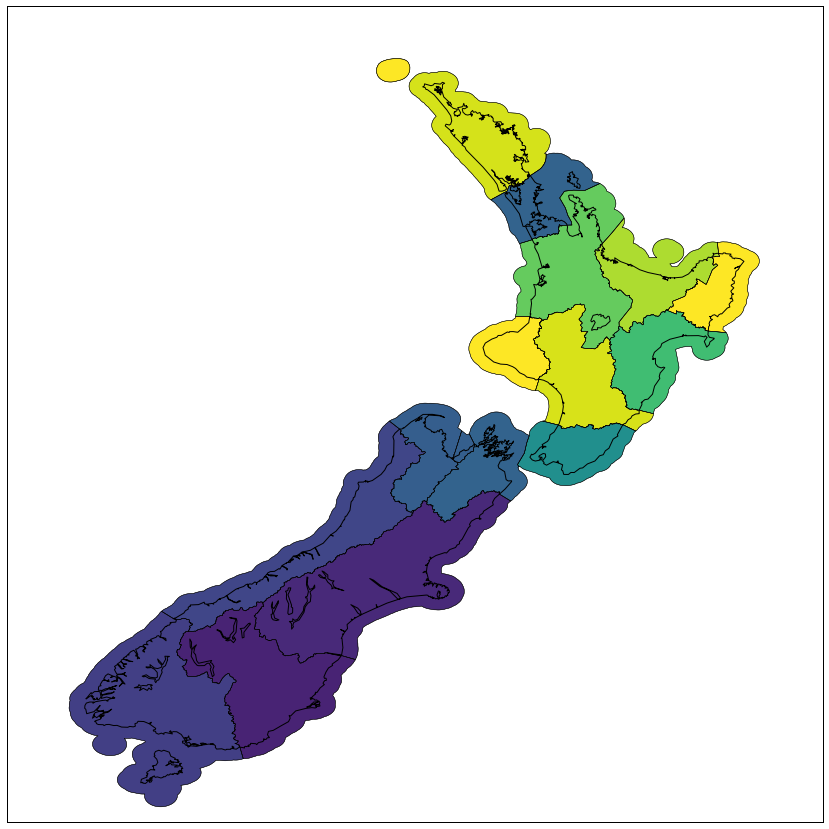

In [119]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
# create new figure, axes instances.

plt.figure(figsize=(15,15))
lonmax = 180
lonmin = 165
latmax = -33
latmin = -48
map = Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax, resolution = 'i')

map.drawmapboundary(fill_color='white')
#Fill the continents with the land color
map.fillcontinents(color='white',lake_color='white')
map.drawcoastlines()

map.readshapefile('../data/raw/statsnzregional-council-2016-generalised-version-SHP/regional-council-2016-generalised-version', 'regional_council')


region_names = []
for shape_dict in map.regional_council_info:
    region_names.append(shape_dict['REGC2016_N'])

ax = plt.gca() # get current axes instance
cm = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0.05, vmax=0.35)

def add_coloured_patch(region_name, colour):
    seg = map.regional_council[region_names.index(region_name)]
    poly = Polygon(seg, facecolor=colour,edgecolor='k')
    ax.add_patch(poly)

for region in region_names:
    add_coloured_patch(region,cm(norm(region_percent[region])))

plt.show()

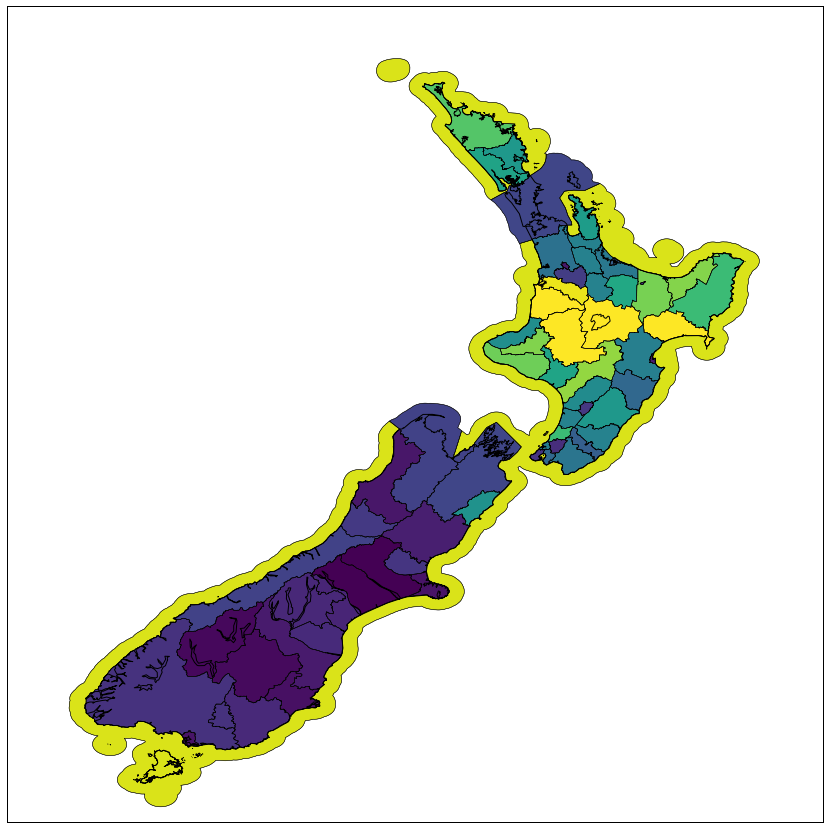

In [117]:
from mpl_toolkits.basemap import Basemap, maskoceans
# create new figure, axes instances.

plt.figure(figsize=(15,15))
map = Basemap(llcrnrlon=165,llcrnrlat=-48,urcrnrlon=180,urcrnrlat=-33, resolution = 'i')

map.drawmapboundary(fill_color='white')
#Fill the continents with the land color
map.fillcontinents(color='white',lake_color='white')
map.drawcoastlines()

map.readshapefile('../data/raw/statsnzterritorial-authority-2017-generalised-version-SHP/territorial-authority-2017-generalised-version', 'territorial_authority')

ax = plt.gca() # get current axes instance
cm = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0.05, vmax=0.50)

for info, shape in zip(map.territorial_authority_info, map.territorial_authority):
    poly = Polygon(shape, facecolor=cm(norm(district_percents[info['TA2017_NAM']])),edgecolor='k')
    ax.add_patch(poly)
      
plt.show()

# Cool road names I came across

Erewhon
Stratford districts many shakespeare references (Falstaff, Prospero, Claudias, Juliet, Caesar)
Phar Lap
Chatham Islands Flower Pot-Glory

# Misclassifications

Usually very "vowelly" words - panorama, horatio, protea
Quite a few spanish (Santa Maria) and native american words (Utah, Ontario(?), Ottawa)